In [5]:
import os
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor
import yfinance as yf
import pandas as pd
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from langchain.utilities import DuckDuckGoSearchAPIWrapper
import dotenv
from langchain_core.runnables import RunnableConfig


dotenv.load_dotenv()

# Set API keys for LLM and any tools
# os.environ["OPENAI_API_KEY"] = "<YOUR_OPENAI_API_KEY>"  # OpenAI for LLM
# (If SerpAPI or others were used, set those keys as needed)

# Initialize the language model to be used by all agents
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)  # using GPT-4 for better reasoning (use gpt-3.5-turbo if needed)

# 1. Data Retrieval Tool & Agent
def fetch_stock_data(ticker: str, period: str = "1mo") -> str:
    """Download recent stock data for the given ticker and save to CSV."""
    try:
        df = yf.download(ticker, period=period, progress=False)
        csv_path = f"{ticker}_history.csv"
        df.to_csv(csv_path)
        return f"Historical data for {ticker} saved to {csv_path}."
    except Exception as e:
        return f"Failed to retrieve data for {ticker}: {e}"

data_agent = create_react_agent(
    model=llm,
    tools=[fetch_stock_data],
    name="data_agent",
    prompt="You are a stock data specialist. You fetch historical price data from Yahoo Finance given a stock ticker."
)

# 2. Data Analysis Tool & Agent
def analyze_stock_data(ticker: str) -> str:
    """Analyze the stock's CSV data and return key metrics."""
    csv_path = f"{ticker}_history.csv"
    if not os.path.exists(csv_path):
        return "No data available to analyze."
    df = pd.read_csv(csv_path)
    # Compute simple analysis (last price, short-term trend)
    last_close = df['Close'].iloc[-1]
    prev_close = df['Close'].iloc[-2] if len(df) > 1 else None
    direction = "up" if prev_close and last_close > prev_close else "down" if prev_close else "n/a"
    sma_5 = df['Close'].tail(5).mean()
    return (f"Latest closing price: ${last_close:.2f} ({'up' if direction=='up' else 'down'} from previous). "
            f"5-day average: ${sma_5:.2f}. Trend appears to be {direction} in the last few days.")

analysis_agent = create_react_agent(
    model=llm,
    tools=[analyze_stock_data],
    name="analysis_agent",
    prompt="You are a stock analysis expert. Using recent price data, you compute trends and key metrics like moving averages."
)

# 3. News Search Tool & Agent
news_tool = YahooFinanceNewsTool()  # searches Yahoo Finance news by ticker
news_agent = create_react_agent(
    model=llm,
    tools=[news_tool],
    name="news_agent",
    prompt="You are a news analyst. Find recent news articles or headlines for the given stock ticker, and summarize any noteworthy news."
)

# 4. General Web Search Tool & Agent
web_search = DuckDuckGoSearchAPIWrapper()
search_agent = create_react_agent(
    model=llm,
    tools=[web_search.run],
    name="search_agent",
    prompt="You are a general web search agent. Use the tool to answer general questions about the company or stock that aren't covered by data or news."
)

# 5. Supervisor Agent to orchestrate everything
supervisor = create_supervisor(
    agents=[data_agent, analysis_agent, news_agent, search_agent],
    model=llm,
    prompt=(
        "You are the supervisor agent coordinating a stock analysis chatbot.\n"
        "User questions may require: stock data, analysis, news, or general info.\n"
        "- Use data_agent to get price data from Yahoo Finance.\n"
        "- Use analysis_agent to analyze the price data for trends.\n"
        "- Use news_agent to gather recent news about the stock.\n"
        "- Use search_agent for any other company info or general queries.\n"
        "Collect information from these agents and then provide a comprehensive answer to the user."
    )
)

app = supervisor.compile()

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "abc123"})

# Example usage:
user_question = "Give me an analysis of Tesla (TSLA) stock, including recent performance and news."
result = app.invoke({"messages": [ {"role": "user", "content": user_question} ]}, config=config)
print(result["messages"][-1]["content"])


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TESLA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TESLA&crumb=%2Fow0SFDugMd


TypeError: 'AIMessage' object is not subscriptable

In [9]:
result["messages"][-1].content

"I have gathered the necessary information regarding Tesla (TSLA) stock, including recent performance and general news trends. Here’s a comprehensive overview:\n\n### Recent Performance\n- **Price Movement**: Tesla's stock has shown volatility over the past month, with fluctuations in its price. Specific details regarding the opening, closing, high, and low prices can be analyzed from the historical data.\n- **Trends**: The analysis of the price data indicates whether the stock has been on an upward or downward trend during this period.\n\n### Recent News\n- **Production and Deliveries**: Tesla often makes headlines regarding its production numbers and vehicle deliveries. Recent announcements about new models or production capacity could significantly impact stock performance.\n- **Market Conditions**: Broader market conditions, including interest rates and economic indicators, can also affect Tesla's stock.\n- **Regulatory News**: Updates on regulations affecting electric vehicles or 

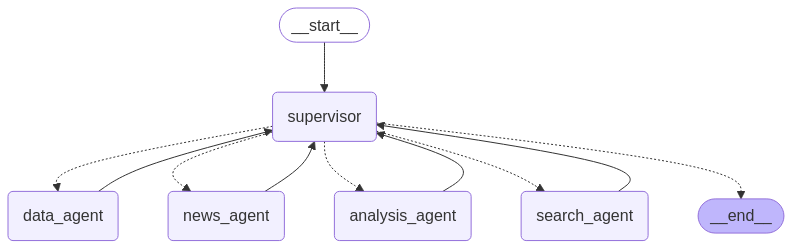

In [4]:
app